In [23]:
import os
import time

import pandas as pd
import numpy as np

from collections import Counter

import torch
from torch.utils.data import DataLoader

from torchvision import transforms
import lib.transforms as mytransforms

from tqdm import tqdm
from PIL import Image

from utils import get_device_name
from lib.utils import load_checkpoint, imshow
from lib.datasets import ShopeeDataset
from lib.sampler import BalancedBatchSampler
from lib.loss import TripletLoss
from lib.utils import pdist_l2
from lib.triplet_selector import BalancedNegativeTripletSelector

import torch.nn.functional as F

In [24]:
import matplotlib.pyplot as plt

def show_images(
    images: torch.Tensor, 
    columns: int, 
    rows: int,
    denormalize: bool = True,
    mean: tuple = (0.485, 0.456, 0.406),
    std: tuple = (0.229, 0.224, 0.225)
):
    fig=plt.figure(figsize=(16, 40))

    for i in range(1, columns * rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.axis('off')
        
        inp = images[i-1].numpy().transpose((1, 2, 0))

        if denormalize:
            inp = np.array(std) * inp + np.array(mean)
            inp = np.clip(inp, 0, 1)
        
        plt.imshow(inp)
    
    return fig

In [25]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    mytransforms.RandomWatermark(p=0.5, watermarks_dir='/app/data/watermarks'),
    mytransforms.RandomText(p=0.5, fonts_dir='/app/data/fonts'),
    mytransforms.RandomBound(p=0.3),
    transforms.Resize((220, 220)),
    mytransforms.RandomResizeWithPad(p=0.7, scale=(0.8, 1), fill_value=256),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    ),
])

In [26]:
train_dataset = ShopeeDataset(
    dataset_path='/data/shopee-product-matching/new_val.csv',
    images_dir='/data/shopee-product-matching/train_images',
    transform=image_transforms
)

In [27]:
# avg_time = []

# for i in tqdm(range(100)):
#     t1 = time.time()
#     tmp = train_dataset[i][0]
#     avg_time.append(time.time() - t1)
# 
# print(np.mean(avg_time))

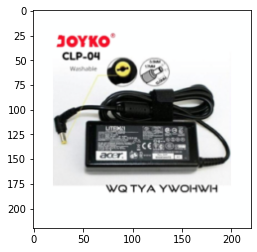

In [38]:
imshow(train_dataset[15][0], show_axis=True)

# C аугментациями

In [18]:
columns = 10
rows = 20

In [19]:
batch_sampler = BalancedBatchSampler(
    train_dataset.labels, 
    n_classes=columns, 
    n_samples=rows
)

train_dataloader = DataLoader(train_dataset, batch_sampler=batch_sampler)

In [20]:
targets = []

for data, labels in tqdm(train_dataloader):
    data = data
    labels = labels.numpy()
    
    targets.extend(labels)
    break

  0%|          | 0/10 [00:02<?, ?it/s]


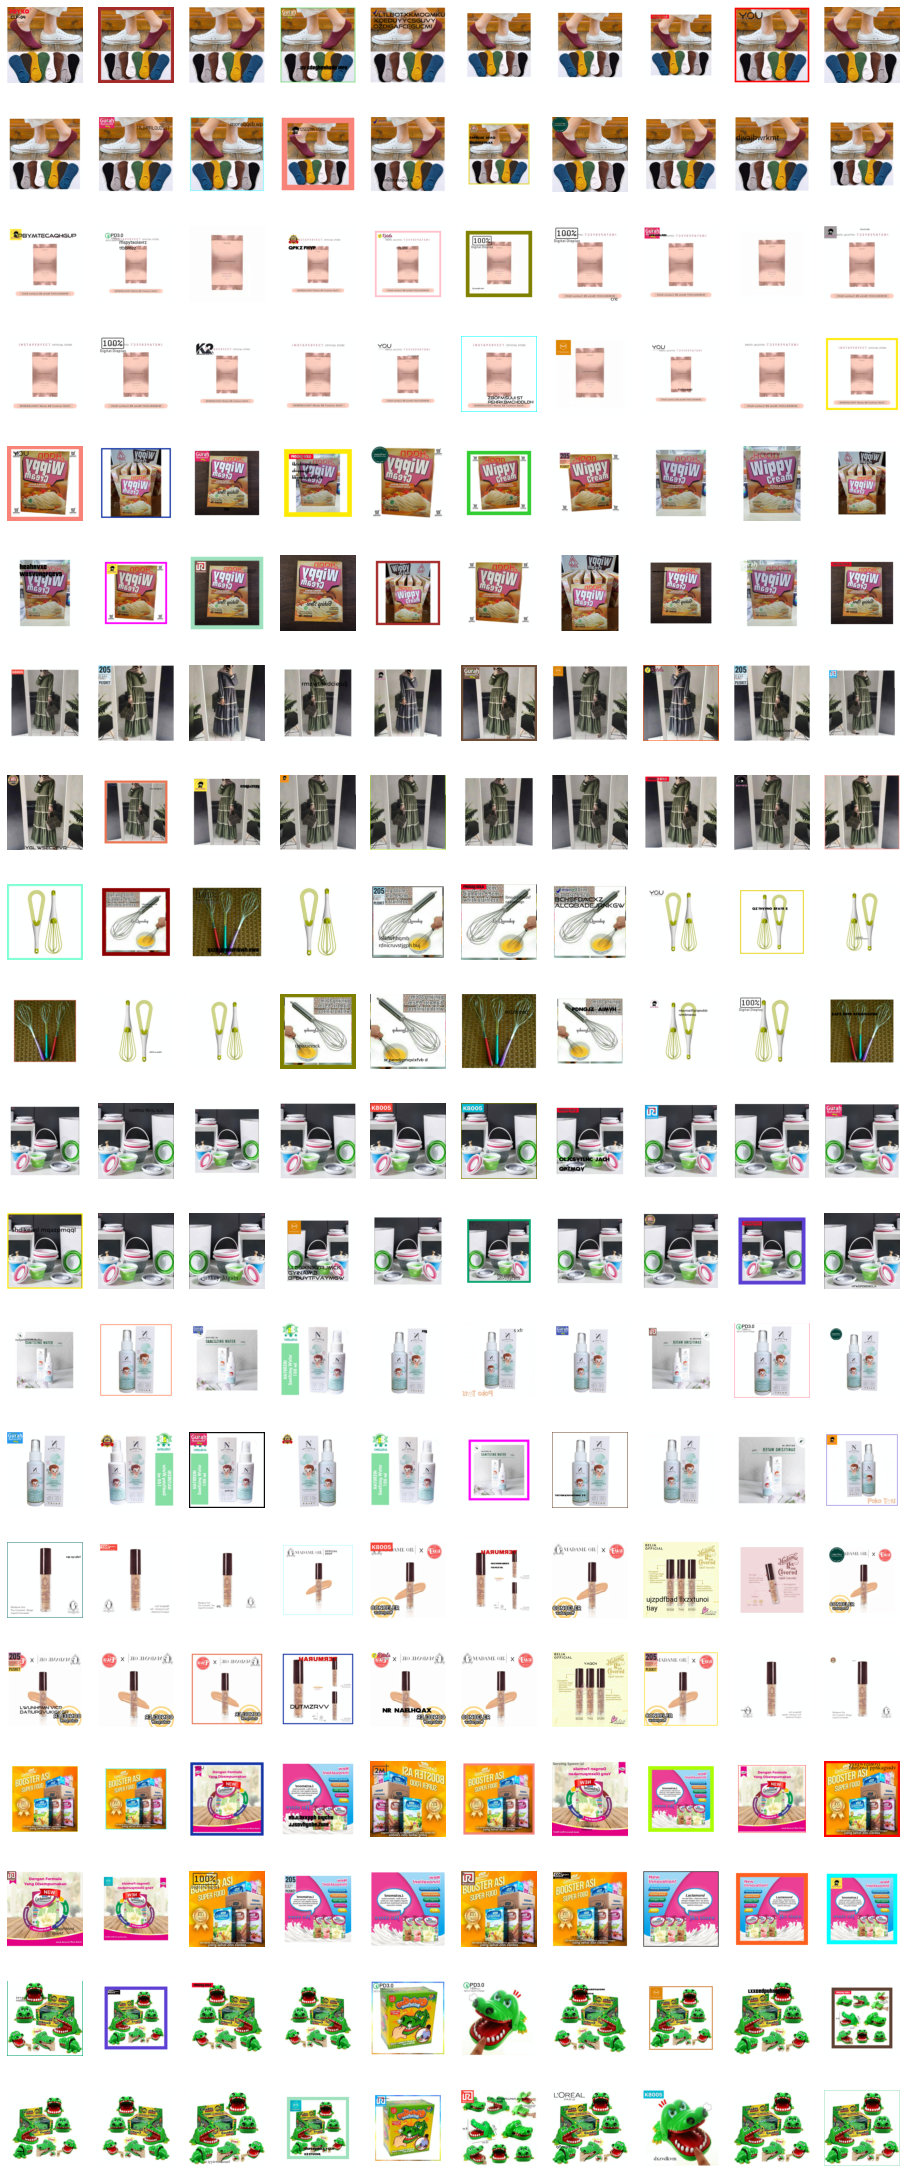

In [21]:
image = show_images(data, columns, rows)

# Без аугментаций

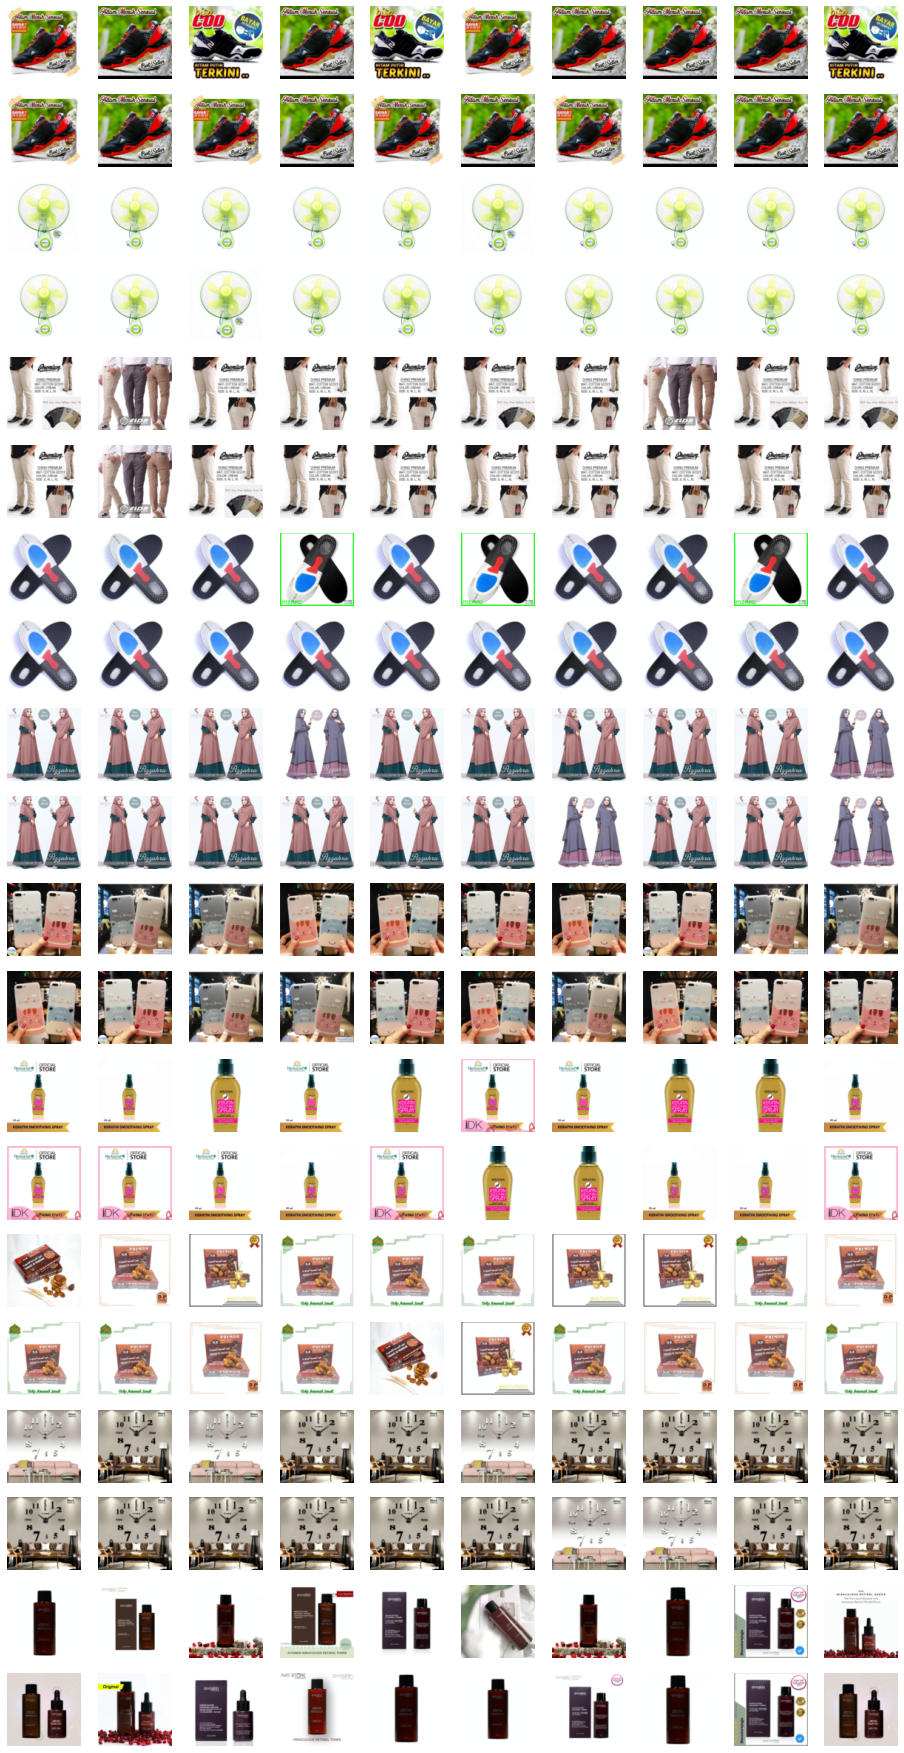

In [136]:
image = show_images(data, columns, rows)